<a href="https://colab.research.google.com/github/natalia0911/Tarea_Practica_2_IA/blob/main/2022_1_Trabajo_Practico_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Instituto Tecnológico de Costa Rica**

**Escuela de Ingeniería en Computación**

**Curso: Inteligencia Artificial**

**Primer Semestre 2022**

**Profesor: Luis-Alexander Calvo-Valverde**

**Trabajo Práctico:** 02

**Datos de la entrega:** Lunes 02 de mayo 2022, a más tardar a las 11:59 pm

**Estudiantes:**
- Natalia Vargas Reyes
- Estudiante_2





___

# Parte 1  -  Ejercicio  (80 puntos)
___

## Introducción

Considere:
- Se le proporciona un conjunto de datos (HousePriceDataset), si desea conocer un poco de los atributos puede consultar en: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data?select=train.csv
- Note que en la página proporcionada se mencionan más atributos de los que contiene el archivo facilitado.  Usaremos como punto de partida para este TP-2, solo los que incluye el archivo adjunto.
- El objetivo de esta parte es ver como el estudiante se enfrenta al proceso de pre-procesamiento, selección de atributos, predicción y evaluación.  Por eso es muy importante que documente en este cuaderno sus decisiones, eso se tomará muy en cuenta en la evaluación de su respuesta.
- El atributo a predecir en regresión se denomina: SalePrice.
- Debe comentar ampliamente su código


In [2]:
%matplotlib inline
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from sklearn.model_selection import train_test_split

### 1 (10 puntos)
- Cargue el archivo.
- Utilice las herramientas (gráficos, funciones que describen contenido o características de las variables, etc) que considere necesarias para analizar los atributos que tiene el dataset y ver si tiene valores faltantes, valores atípicos, etc.
- Comente sus conclusiones sobre los atritubos.


In [4]:
dataset = pd.read_csv('HousePriceDataset.csv', header = 0, delimiter=';')  
#print(dataset.describe())
print(dataset.head(5))

   Id  MSSubClass MSZoning Neighborhood  OverallQual RoofStyle BsmtQual  \
0   1          60       RL      CollgCr            7     Gable       Gd   
1   2          20       RL      Veenker            6     Gable       Gd   
2   3          60       RL      CollgCr            7     Gable       Gd   
3   4          70       RL      Crawfor            7     Gable       TA   
4   5          60       RL      NoRidge            8     Gable       Gd   

  HeatingQC CentralAir  1stFlrSF  GrLivArea  BsmtFullBath KitchenQual  \
0        Ex          Y       856       1710             1          Gd   
1        Ex          Y      1262       1262             0          TA   
2        Ex          Y       920       1786             1          Gd   
3        Gd          Y       961       1717             1          Gd   
4        Ex          Y      1145       2198             1          Gd   

  GarageType GarageFinish  GarageCars PavedDrive  SalePrice  
0     Attchd          RFn           2          Y

####Matriz de correlación
Con esta podemos ver de manera sencilla la relación entre los valores de los distintos atributos, aunque para este caso solo los numéricos.
Un valor de correlación alto y positivo indica que los elementos miden la misma destreza o característica.

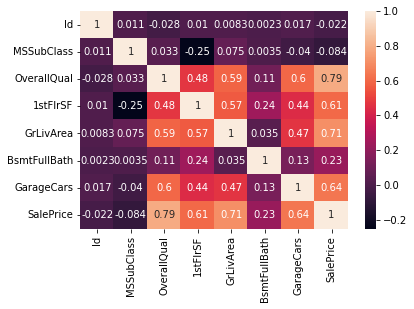

In [45]:
corrMatrix = dataset.corr()
sn.heatmap(corrMatrix, annot=True)

####Histogramas
A continuación se muestran histogramas de los atributos. Esto nos permitirá ver las distribuciones de los mismos, y determinar cuales son ordinales o categoricos, de manera que más adelante se puedan tomar las medidas del caso codificando esos determinados atributos.

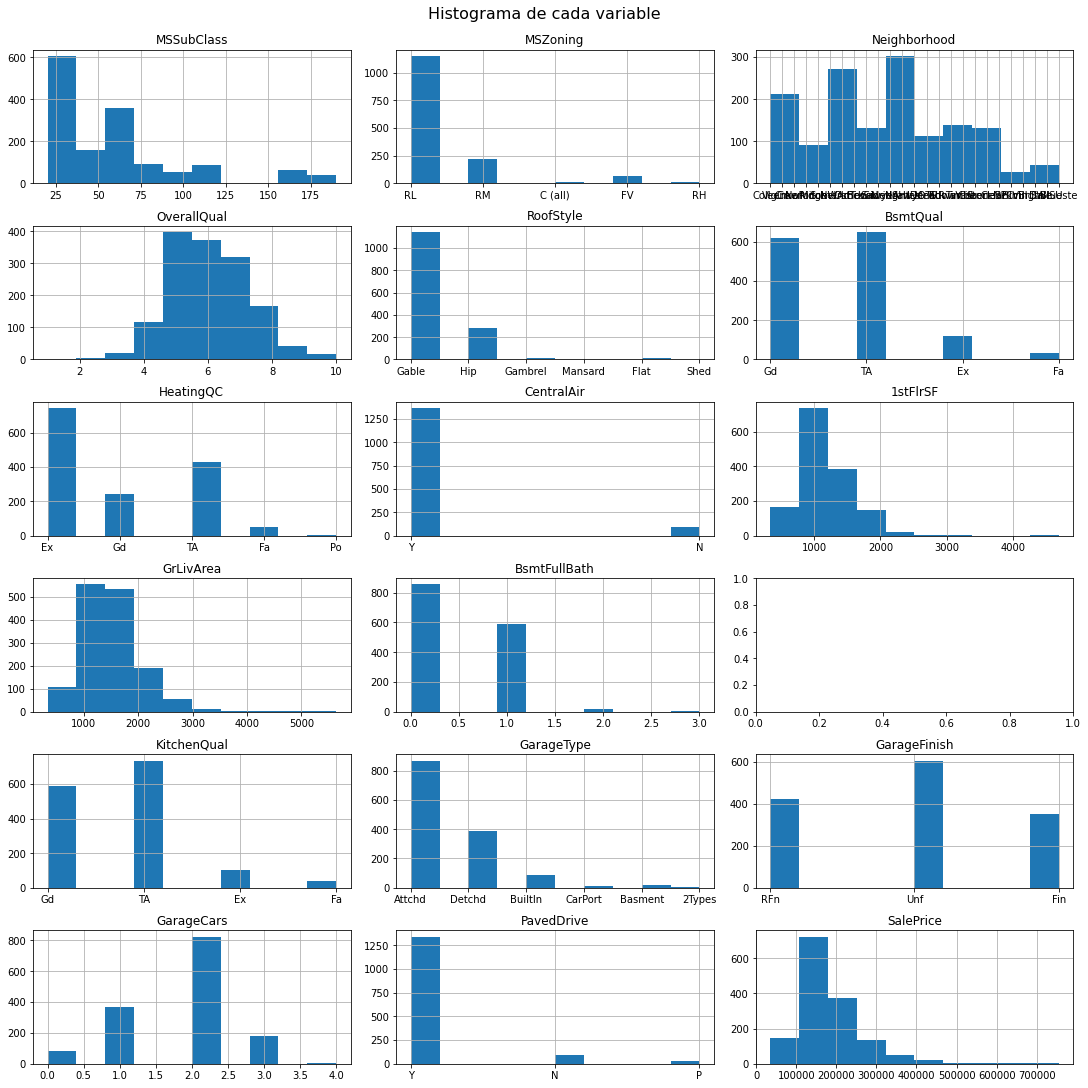

In [46]:
# Se grafica con un histograma cada uno de los atributos
fig, axs = plt.subplots(6, 3, constrained_layout=True, figsize=(15,15))
fig.suptitle('Histograma de cada variable', fontsize=16)

d = 1
for i in range(6):
  for j in range(3):
    if i == 3 and j == 2:
      break
    else:
      axs[i,j].set_title(dataset.columns[d])
      dataset.iloc[:, d].hist(ax=axs[i,j])
      d += 1
plt.show()

Como se puede observar con las gráficas, tenemos varios atributos que se podrían codificar, tal es el caso de MSZoning, Neighborhood, RoofStyle, CentralAir, GarageType, GarageFinish, y PavedDrive.

Por otro lado, las variables BsmtQual, HeatingQC, KitchenQual, parecen ser ordinales, pues se manejan con valores Ex, Gd, TA, Fa, Po, de Excellent, Good, Typical average, Fair, y Poor, es decir que y tienen un orden especifico, pues unos valores pesan más que otros. 

####Diagrama de cajas y bigotes

In [13]:
print(dataset.dtypes)

Id               int64
MSSubClass       int64
MSZoning        object
Neighborhood    object
OverallQual      int64
RoofStyle       object
BsmtQual        object
HeatingQC       object
CentralAir      object
1stFlrSF         int64
GrLivArea        int64
BsmtFullBath     int64
KitchenQual     object
GarageType      object
GarageFinish    object
GarageCars       int64
PavedDrive      object
SalePrice        int64
dtype: object


Se imprimieron los tipos de los datos para verificar cuáles se podían graficar en un diagrama de bigotes, el cuál nos ayudará a detectar outliers.

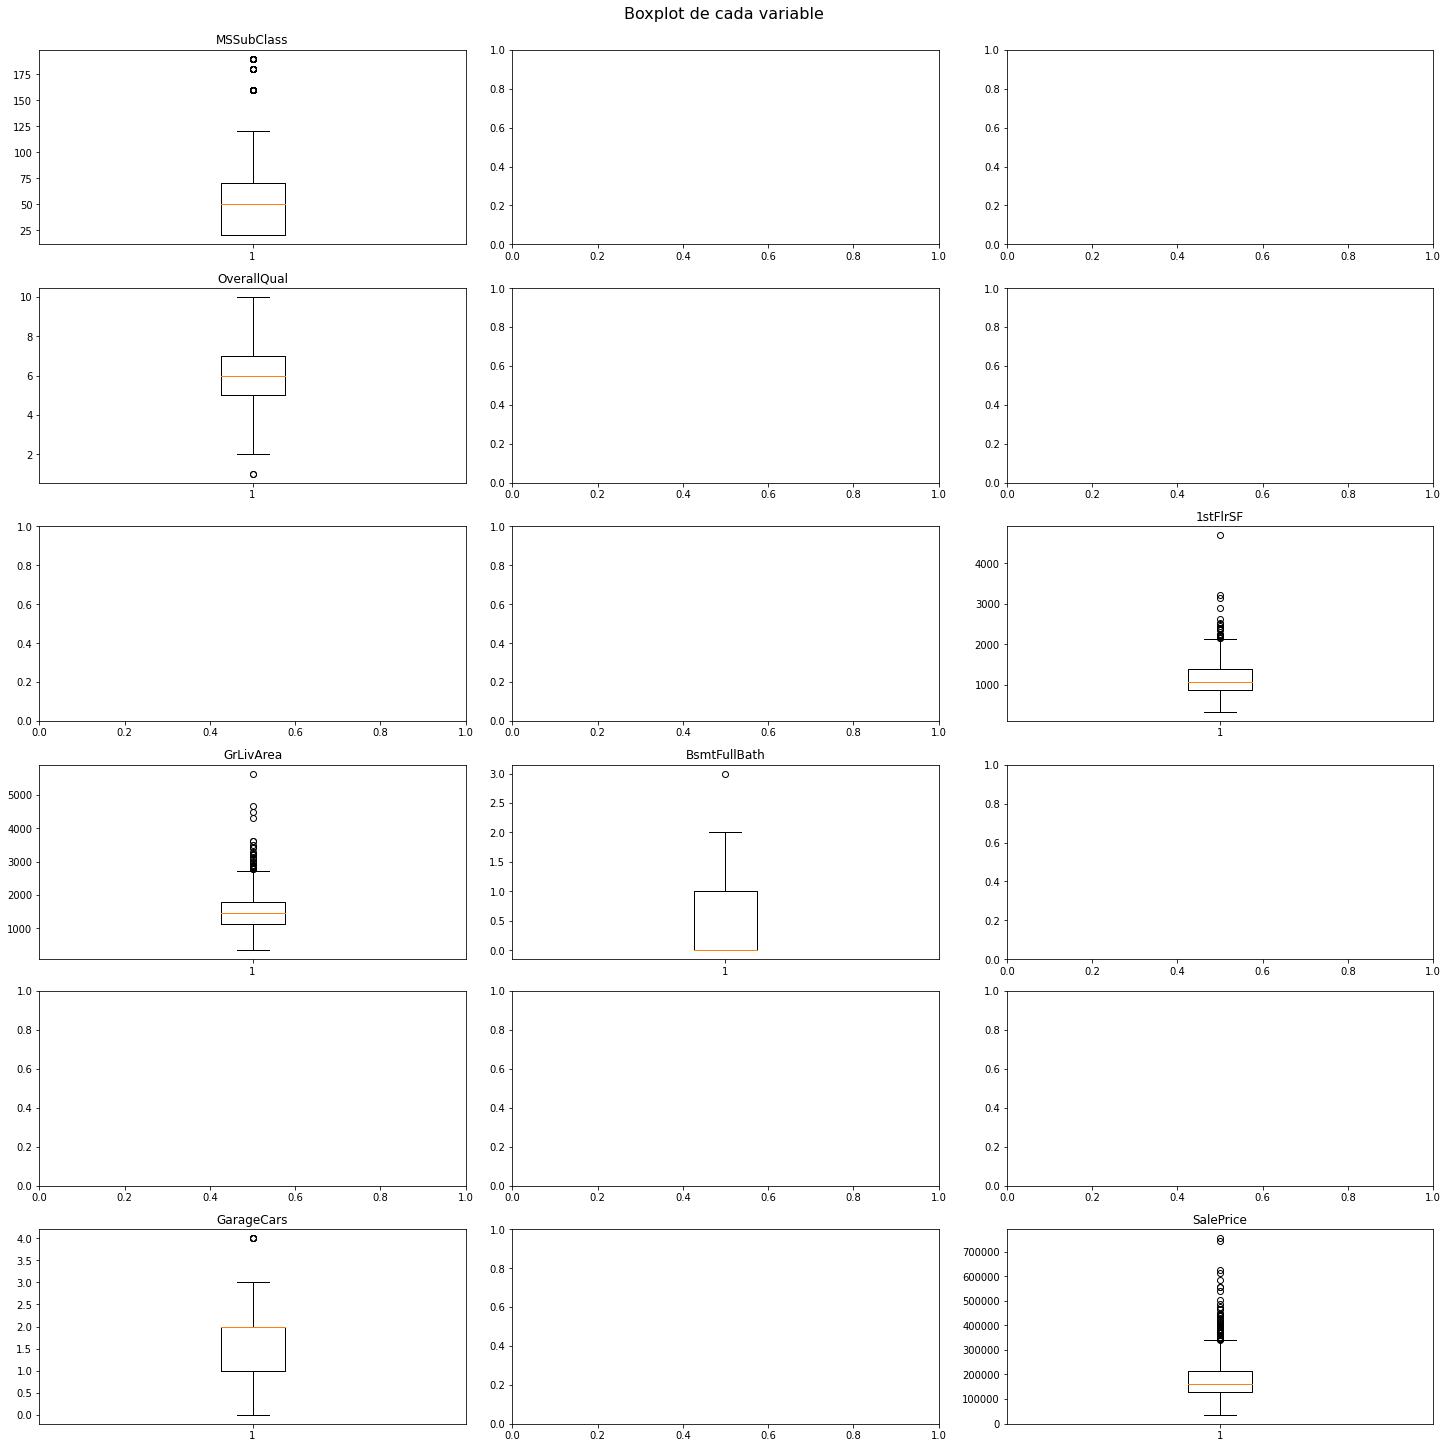

In [77]:

# Se grafica con un boxplot cada uno de los atributos enteros
fig, axs = plt.subplots(6, 3, constrained_layout=True, figsize=(20,20))
fig.suptitle('Boxplot de cada variable', fontsize=16)

d = 1
for i in range(6):
  for j in range(3):
    if i == 3 and j == 2:
      break
    else:
      if dataset[dataset.columns[d]].dtypes == "int64":
        axs[i,j].set_title(dataset.columns[d])
        axs[i,j].boxplot(dataset.iloc[:,d])
      d += 1


Podemos notar que las variables presentan valores atípicos, con esto podemos comprobar que hace falta hacer un tratamiento de esos. De momento esto nos sirve para observar de manera gráfica que hay valores que se alejan mucho de la media. Más adelante podemos revisar las filas que tienen outliers y hacer algún preprocesamiento de los mismos.

Resumen Estadístico----------------
        MSSubClass
count  1460.000000
mean     56.897260
std      42.300571
min      20.000000
25%      20.000000
50%      50.000000
75%      70.000000
max     190.000000
10      False
11      False
12      False
13      False
14      False
        ...  
1455    False
1456    False
1457    False
1458    False
1459    False
Name: MSSubClass, Length: 1450, dtype: bool
Encontrar outliers-----------------
1       20
6       20
10      20
12      20
13      20
        ..
1453    20
1454    20
1456    20
1458    20
1459    20
Name: MSSubClass, Length: 536, dtype: int64
9       190
48      190
93      190
125     190
165     190
246     190
291     190
300     190
312     190
335     190
411     190
488     190
520     190
535     190
635     190
637     190
703     190
705     190
713     190
861     190
969     190
985     190
1030    190
1062    190
1144    190
1186    190
1190    190
1266    190
1393    190
1416    190
Name: MSSubClass, dtype: int64


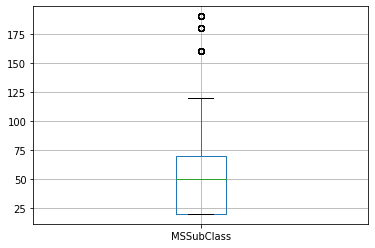

In [25]:
#PRUEBASSS
data = pd.DataFrame(dataset.MSSubClass)
data.boxplot()

print("Resumen Estadístico----------------")
print(data.describe())

values = dataset.MSSubClass
q1 = dataset['MSSubClass'].quantile(0.25)
q3 = dataset['MSSubClass'].quantile(0.75)
IQR = q3 - q1
lb = q1 - 1.5 * IQR
ub = q1 + 1.5 * IQR
ls =  (dataset['MSSubClass']<lb) | (dataset['MSSubClass']>ub) 

'''
print(q1)
print(q3)
print(lb)
print(ub)
'''
print(ls[10:])


values = dataset.MSSubClass
print("Encontrar outliers-----------------")
print(values[values.between(values.quantile(0), values.quantile(.003))] )
print(values[values.between(values.quantile(.997), values.quantile(1))] )


####Valores faltantes
Aparte de observar los datos y notar que hay valores faltantes, podemos imprimir cuantos valores hay para cada atributo, y como sabemos que tenemos 1460 filas o muestras, notar que uno de los atributos de menos de eso, indicaría que hay valores que más adelante tendremos que tratar, ya sea rellenarlos, ignorarlos o usar algún algoritmo más complejo. 

In [11]:
print("Cantidad de muestras ",len(dataset), "\n")
print(dataset.count())


Cantidad de muestras  1460 

Id              1460
MSSubClass      1460
MSZoning        1460
Neighborhood    1460
OverallQual     1460
RoofStyle       1460
BsmtQual        1423
HeatingQC       1460
CentralAir      1460
1stFlrSF        1460
GrLivArea       1460
BsmtFullBath    1460
KitchenQual     1460
GarageType      1379
GarageFinish    1379
GarageCars      1460
PavedDrive      1460
SalePrice       1460
dtype: int64


### 2 (5 puntos)
- Se utilizará el modelo Train/Validation (70%)  y Test (30%). 
- Comente su decisión sobre los parámetros shuffle y random_state
- Separe  los  conjuntos de datos (70-30) (X_trainVal, X_test, y_trainVal, y_test )
- Muestre los primeros 5 registros de cada conjunto.


Primero se separan las columnas

In [10]:
my_data = pd.DataFrame(dataset).to_numpy()
X = my_data[:,0:-1]
cantidad_muestras = len(my_data)
y = my_data[:,-1]

print("\nMuestra fila 1: ",X[0:1])
print("\nCantidad de muestras: ", len(my_data))
print("\nCantidad de atributos (incluye y): ", len(my_data[0]))



Muestra fila 1:  [[1 60 'RL' 'CollgCr' 7 'Gable' 'Gd' 'Ex' 'Y' 856 1710 1 'Gd' 'Attchd'
  'RFn' 2 'Y']]

Cantidad de muestras:  1460

Cantidad de atributos (incluye y):  18


In [16]:

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    train_size=0.70,
                                                    shuffle=True,     #Mezclar los datos y que se reparta aleatoriamente
                                                    random_state=10)  #Definir una semilla para usar los mismos valores en todas las corridas

print("\nTamaño de X_train + X_test: ", len(X_train)+len(X_test))
print("\nTamaño del train: ", len(X_train))
print("\nTamaño del test: ", len(X_test))
print("\nPrimeros elementos del X_train:")
print( X_train[0:5])
print("\nPrimeros elementos del X_test:")
print( X_test[0:5])
print("\nPrimeros elementos del y_train:")
print( y_train[0:5])
print("\nPrimeros elementos del y_test:")
print( y_test[0:5])


Tamaño de X_train + X_test:  1459

Tamaño del train:  1021

Tamaño del test:  438

Primeros elementos del X_train:
[[913 30 'RM' 'BrkSide' 5 'Gable' 'TA' 'TA' 'N' 1015 1015 0 'TA' 'Detchd'
  'Unf' 1 'Y']
 [374 20 'RL' 'NAmes' 5 'Gable' 'TA' 'TA' 'Y' 1319 1319 1 'TA' 'Attchd'
  'Unf' 1 'Y']
 [21 60 'RL' 'NridgHt' 8 'Gable' 'Ex' 'Ex' 'Y' 1158 2376 0 'Gd' 'BuiltIn'
  'RFn' 3 'Y']
 [801 60 'RL' 'ClearCr' 6 'Gable' 'Gd' 'Gd' 'Y' 616 1688 1 'Gd' 'Attchd'
  'RFn' 2 'Y']
 [153 60 'RL' 'NWAmes' 6 'Gable' 'TA' 'Gd' 'Y' 1097 1993 0 'TA' 'Attchd'
  'RFn' 2 'Y']]

Primeros elementos del X_test:
[[855 20 'RL' 'Sawyer' 5 'Hip' 'TA' 'TA' 'Y' 1779 1779 1 'TA' 'Attchd'
  'Unf' 2 'Y']
 [382 20 'FV' 'Somerst' 7 'Gable' 'Gd' 'Ex' 'Y' 1301 1301 1 'Gd' 'Attchd'
  'RFn' 2 'Y']
 [817 20 'RL' 'NAmes' 5 'Gable' 'TA' 'Gd' 'Y' 1008 1008 0 'TA' 'Attchd'
  'RFn' 1 'Y']
 [578 80 'RL' 'Sawyer' 5 'Gable' 'TA' 'Ex' 'Y' 1320 1320 1 'TA' 'Attchd'
  'RFn' 2 'Y']
 [36 60 'RL' 'NridgHt' 8 'Gable' 'Ex' 'Ex' 'Y' 1132 2452 0 '

####Comentario sobre shuffle y random_state
Shuffle es un atributo que se debe poner en True si se quieren mezclar los datos, esto nos ayudará con la aletoriedad y en este caso se decidió hacer de esta forma porque es eso precesimente lo que andamos buscando al separar el train del test.
Por otro lado el random_state, se debe poner en algún valor, un valor inicial que se define por medio de una semilla y es importante ponerlo si queremos que en todas las corridas se usen los mismos valores random, esto es muy útil cuando se trabaja con muestras y no poner un valor en el atributo haría que cada vez que se ejecute el programa, se use uno distinto y por lo tanto cada vez use valores diferentes. 

##NO SÉ POR QUÉ EL 10, NO SÉ EN BASE A QUÉ ESCOJO LA SEMILLA, SIENTO QUE DA IGUAL XD

### 3  (15 puntos)
- Preprocese los atributos (Solo deje para más adelante escalar los datos).
- Debe comentar en celdas del texto el por qué seleccionó las técnicas utilizadas.

### 4 (10 puntos)
- Realice selección de atributos.
- Debe utilizar al menos una técnica para justificar su decisión (De entre los métodos: Filter, Wrapper, Embedded).
- ¿Qué hará con el atributo denominado: "Id"?
- Comente sus conclusiones.


### 1.5  (5 puntos)
- Escale los datos.
- Comente qué técnica utilizó y por qué.
- Guarde el archivo ya pre-procesado con el nombre: "'HousePriceDatasetPROCESADO"

**Nota:** No olvide cómo manejará el "bias" (o agregar columna de unos, o si la implementación de los algoritmos que utilizará permiten indicarle que lo agregue).


### 1.6 (20 puntos)
Presente e implemente un diseño experimental que incluya:
- Tres algoritmos diferentes:
    - Uno será la regresión lineal de mínimos cuadrados sin regularización (OLSR).
    - Usted eligirá un método más, que no sea de los vistos en clase. Si tiene dudas de si puede o no usar algún método, puede consultar al profesor.
    - Como el OLSR no tiene hiperparámetros, use todo el train/validation para entrenar. Para los otros dos métodos, debe usar ten-cross-validation para seleccionar al menos un hiperparámetro.
    - Debe registrar las métricas RMSE y R2. Usted decide cuál de estas dos métricas usa para selecionar la mejor configuración (Justifique su selección).
    
**Nota:** Para cada el algoritmo adicional seleccionado (no el OLSR) explique los parámetros que recibe. 
    

### 1.7 (15 puntos)

- Por medio de una tabla u otro método idóneo que Usted determine, resuma todos los resultados obtenidos (o la mayoría).
- Grafique comparativamente los valores del real versus el predicho (test), de cada uno de los métodos utilizados.  
- Qué conclusiones finales saca sobre los métodos usados como predictores.

___

# Parte 2  -  Temas por grupo (20 puntos)
___

Considere lo siguiente:
1. Revise en el archivo PDF: "Temas por grupo", qué cuadernos jupyter le corresponden a su grupo.
1. Estudie los cuadernos asignados.
1. Prepare un único cuaderno de jupyter (comentando con celdas de texto en español), en que resume y explica las técnicas asignadas.  Debe buscar uno o más datasets diferentes a los que se usan en los cuadernos de jupyter asignados. Deberá adjuntar a su solución el cuaderno jupyter generado y el o los datasets que Usted propone usar en sus cuadernos.
1. Prepare un video para una posible presentación de sus temas en clase, no debe durar más 15 minutos en la presentación de los temas asignados (Considere que el material preparado será compartido con sus compañer(a/o)s del curso y por tanto se espera que se esmere en su elaboración y clara explicación -- por favor -- ).